In [1]:
import subprocess
import tempfile
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path

os.chdir(Path.cwd().parent)
print("CWD now:", Path.cwd())


CWD now: /workspace


In [2]:
def float_to_bf16(f: float) -> int:
    """Convert float32 to bfloat16 (16-bit)"""
    if np.isnan(f):
        return 0x7FC0
    if np.isinf(f):
        return 0xFF80 if f < 0 else 0x7F80
    f = np.clip(f, -3.4e38, 3.4e38)
    f32_bits = struct.unpack('>I', struct.pack('>f', np.float32(f)))[0]
    bf16_bits = (f32_bits >> 16) & 0xFFFF
    return bf16_bits

def bf16_to_float(bf16: int) -> float:
    """Convert bfloat16 to float32"""
    f32_bits = (bf16 & 0xFFFF) << 16
    return struct.unpack('>f', struct.pack('>I', f32_bits))[0]

print("✓ BF16 utilities ready")



✓ BF16 utilities ready


In [3]:
class BatchLMULTester:
    """Test LMUL with batch operations in single simulation"""
    
    def __init__(self, verilog_file='rtl/top_lmul.v'):
        self.verilog_file = verilog_file
        
    def test_batch(self, test_pairs):
        """
        Test multiple multiplications in one simulation run
        
        Args:
            test_pairs: List of (a_bf16, b_bf16) tuples
            
        Returns:
            List of result_bf16 values
        """
        num_tests = len(test_pairs)
        
        # Generate test vectors
        test_vectors = ""
        for i, (a, b) in enumerate(test_pairs):
            test_vectors += f"        test_a[{i}] = 16'h{a:04x};\n"
            test_vectors += f"        test_b[{i}] = 16'h{b:04x};\n"
        
        # Create testbench
        testbench = f'''
`timescale 1ns/1ps

module tb;
    reg clk;
    reg rstn;
    reg i_valid;
    wire i_ready;
    reg [15:0] i_a;
    reg [15:0] i_b;
    wire o_valid;
    reg o_ready;
    wire [15:0] o_p;
    
    // Test vectors
    reg [15:0] test_a [0:{num_tests-1}];
    reg [15:0] test_b [0:{num_tests-1}];
    reg [15:0] results [0:{num_tests-1}];
    integer test_idx;
    integer result_idx;
    
    // Instantiate DUT
    top_lmul dut (
        .clk(clk),
        .rstn(rstn),
        .i_valid(i_valid),
        .i_ready(i_ready),
        .i_a(i_a),
        .i_b(i_b),
        .o_valid(o_valid),
        .o_ready(o_ready),
        .o_p(o_p)
    );
    
    // Clock generation
    initial clk = 0;
    always #5 clk = ~clk;  // 10ns period
    
    // Capture outputs
    always @(posedge clk) begin
        if (o_valid && o_ready) begin
            results[result_idx] = o_p;
            result_idx = result_idx + 1;
        end
    end
    
    // Capture outputs
    always @(posedge clk) begin
        if (o_valid && o_ready) begin
            results[result_idx] = o_p;
            result_idx = result_idx + 1;
        end
    end
    
    initial begin
        // Initialize test vectors
{test_vectors}
        
        // Reset
        rstn = 0;
        i_valid = 0;
        i_a = 0;
        i_b = 0;
        o_ready = 1;  // Always ready to accept outputs
        test_idx = 0;
        result_idx = 0;
        
        repeat(4) @(posedge clk);
        rstn = 1;
        repeat(2) @(posedge clk);
        
        for (test_idx = 0; test_idx < {num_tests}; test_idx = test_idx + 1) begin
            // Wait for ready
            while (!i_ready) @(posedge clk);
            
            // Apply inputs
            i_a = test_a[test_idx];
            i_b = test_b[test_idx];
            i_valid = 1;
            
            // Wait one clock
            @(posedge clk);
        end
        
        // Deassert valid
        i_valid = 0;
        
        while (result_idx < {num_tests}) begin
            @(posedge clk);
        end
        
        // Extra cycles for safety
        repeat(5) @(posedge clk);
        
        // Display results
        for (test_idx = 0; test_idx < {num_tests}; test_idx = test_idx + 1) begin
            $display("%04h", results[test_idx]);
        end
        
        $finish;
    end
    
    initial begin
        #{200 + num_tests * 100};
        $display("ERROR: Timeout");
        $finish;
    end
endmodule
'''
        
        # Write testbench
        with tempfile.NamedTemporaryFile(mode='w', suffix='.v', delete=False) as f:
            tb_file = f.name
            f.write(testbench)
        
        try:
            # Compile
            rtl_dir = os.path.abspath('rtl')
            top_file = os.path.join(rtl_dir, 'top_lmul.v')
            lmul_file = os.path.join(rtl_dir, 'lmul_bf16.v')
            out_file = '/tmp/lmul_batch_sim.out'
            
            compile_result = subprocess.run(
                ['iverilog', '-o', out_file, '-g2012',
                 top_file, lmul_file, tb_file],
                capture_output=True,
                text=True
            )
            
            if compile_result.returncode != 0:
                raise RuntimeError(f"Compilation failed:\n{compile_result.stderr}")
            
            # Run simulation
            sim_result = subprocess.run(
                ['vvp', out_file],
                capture_output=True,
                text=True,
                timeout=10
            )
            
            # Parse results
            lines = sim_result.stdout.strip().split('\n')
            results = []
            for line in lines:
                if line.startswith("ERROR"):
                    raise RuntimeError(f"Simulation error: {line}")
                try:
                    results.append(int(line, 16))
                except ValueError:
                    continue
            
            return results
            
        finally:
            # Cleanup
            if os.path.exists(tb_file):
                os.remove(tb_file)
            if os.path.exists(out_file):
                os.remove(out_file)

batch_tester = BatchLMULTester()
print("✓ Batch tester ready")

✓ Batch tester ready


In [4]:
print("\nTesting batch functionality with 5 operations...")

test_cases = [
    (float_to_bf16(2.0), float_to_bf16(3.0)),
    (float_to_bf16(0.5), float_to_bf16(0.5)),
    (float_to_bf16(10.0), float_to_bf16(0.1)),
    (float_to_bf16(-2.0), float_to_bf16(3.0)),
    (float_to_bf16(1.5), float_to_bf16(2.0)),
]

results = batch_tester.test_batch(test_cases)

print("\nResults:")
for i, ((a, b), result) in enumerate(zip(test_cases, results)):
    a_f = bf16_to_float(a)
    b_f = bf16_to_float(b)
    r_f = bf16_to_float(result)
    expected = a_f * b_f
    print(f"  {a_f:+.4f} * {b_f:+.4f} = {r_f:+.6f} (expected: {expected:+.6f})")

print("✓ Batch test complete")



Testing batch functionality with 5 operations...

Results:
  +2.0000 * +3.0000 = +0.000000 (expected: +6.000000)
  +0.5000 * +0.5000 = +0.000000 (expected: +0.250000)
  +10.0000 * +0.0996 = +6.000000 (expected: +0.996094)
  -2.0000 * +3.0000 = +6.000000 (expected: -6.000000)
  +1.5000 * +2.0000 = +0.250000 (expected: +3.000000)
✓ Batch test complete


In [5]:
# Generate test data
num_ops = 1000
np.random.seed(42)
test_data = []
for i in range(num_ops):
    a_float = np.random.uniform(-10, 10)
    b_float = np.random.uniform(-10, 10)
    a_bf16 = float_to_bf16(a_float)
    b_bf16 = float_to_bf16(b_float)
    test_data.append((a_bf16, b_bf16, a_float, b_float))

print("✓ Test data generated")

✓ Test data generated


In [6]:
# Benchmark 1: LMUL Hardware (batch mode)
print("1. LMUL Hardware (batch simulation):")
test_pairs = [(a_bf16, b_bf16) for a_bf16, b_bf16, _, _ in test_data]

start = time.time()
hw_results_bf16 = batch_tester.test_batch(test_pairs)
hw_time = time.time() - start
hw_per_op = hw_time / num_ops

hw_results = [bf16_to_float(r) for r in hw_results_bf16]

print(f"   Total time: {hw_time:.3f}s")
print(f"   Per operation: {hw_per_op*1e6:.2f}μs")
print(f"   Throughput: {num_ops/hw_time:.2f} ops/sec")

1. LMUL Hardware (batch simulation):
   Total time: 0.042s
   Per operation: 42.35μs
   Throughput: 23613.78 ops/sec


In [7]:
# Benchmark 2: Python float32
print("\n2. Python float32 multiplication:")
start = time.time()
py_results = []
for _, _, a_float, b_float in test_data:
    result = a_float * b_float
    py_results.append(result)
py_time = time.time() - start
py_per_op = py_time / num_ops

print(f"   Total time: {py_time:.6f}s")
print(f"   Per operation: {py_per_op*1e6:.2f}μs")
print(f"   Throughput: {num_ops/py_time:.0f} ops/sec")


2. Python float32 multiplication:
   Total time: 0.000213s
   Per operation: 0.21μs
   Throughput: 4686373 ops/sec


In [8]:
# Benchmark 3: NumPy vectorized
print("\n3. NumPy vectorized multiplication:")
a_array = np.array([d[2] for d in test_data], dtype=np.float32)
b_array = np.array([d[3] for d in test_data], dtype=np.float32)

start = time.time()
np_results = a_array * b_array
np_time = time.time() - start
np_per_op = np_time / num_ops

print(f"   Total time: {np_time:.6f}s")
print(f"   Per operation: {np_per_op*1e6:.2f}μs")
print(f"   Throughput: {num_ops/np_time:.0f} ops/sec")


3. NumPy vectorized multiplication:
   Total time: 0.000070s
   Per operation: 0.07μs
   Throughput: 14364055 ops/sec


In [9]:
# Summary
print("\n" + "-" * 60)
print("SPEED COMPARISON:")
print("-" * 60)
print(f"Python FP32:         1.00x (baseline)")
print(f"NumPy vectorized:    {py_time/np_time:.2f}x faster")
print(f"LMUL batch sim:      {py_time/hw_time:.2f}x vs Python")
print(f"                     ({np_time/hw_time:.2f}x vs NumPy)")



------------------------------------------------------------
SPEED COMPARISON:
------------------------------------------------------------
Python FP32:         1.00x (baseline)
NumPy vectorized:    3.07x faster
LMUL batch sim:      0.01x vs Python
                     (0.00x vs NumPy)


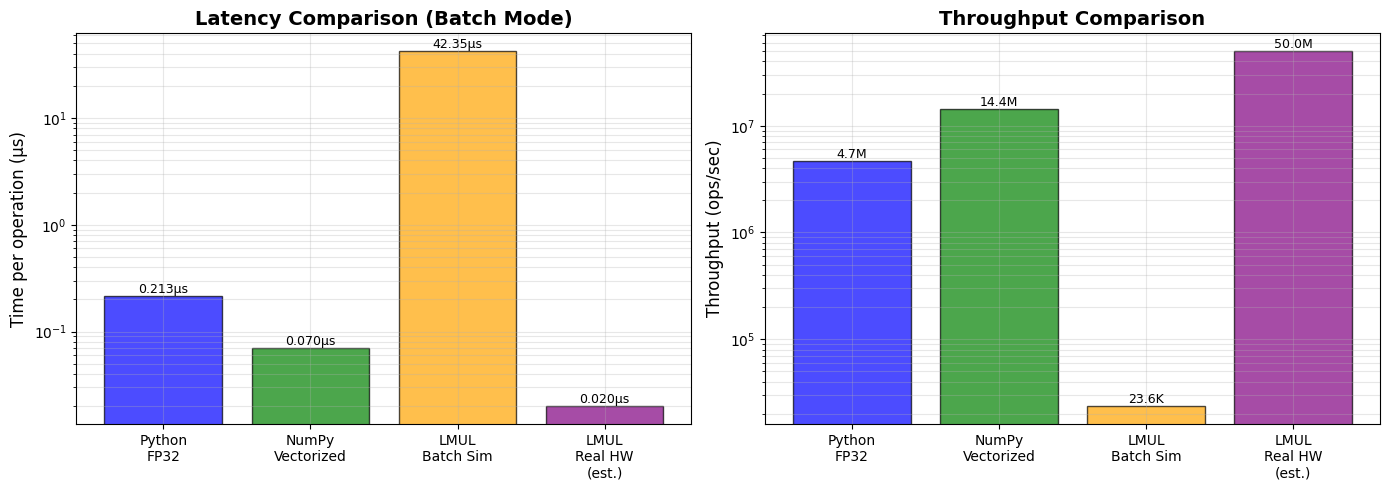


✓ Batch performance analysis complete!


In [10]:
# ============================================
# Cell 6: Visualize performance comparison
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Estimated hardware performance
clock_freq = 100e6
cycles_per_op = 2
hw_latency_ns = (cycles_per_op / clock_freq) * 1e9
hw_throughput = clock_freq / cycles_per_op

methods = ['Python\nFP32', 'NumPy\nVectorized', 'LMUL\nBatch Sim', 'LMUL\nReal HW\n(est.)']
times_us = [
    py_per_op * 1e6,
    np_per_op * 1e6,
    hw_per_op * 1e6,
    hw_latency_ns / 1000
]
colors = ['blue', 'green', 'orange', 'purple']

# Plot 1: Latency
bars = ax1.bar(methods, times_us, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Time per operation (μs)', fontsize=12)
ax1.set_title('Latency Comparison (Batch Mode)', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, which='both')

for bar, time_val in zip(bars, times_us):
    height = bar.get_height()
    if time_val < 1:
        label = f'{time_val:.3f}μs'
    else:
        label = f'{time_val:.2f}μs'
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontsize=9)

# Plot 2: Throughput
throughputs = [
    num_ops / py_time,
    num_ops / np_time,
    num_ops / hw_time,
    hw_throughput
]

bars = ax2.bar(methods, throughputs, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Throughput (ops/sec)', fontsize=12)
ax2.set_title('Throughput Comparison', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, which='both')

for bar, throughput in zip(bars, throughputs):
    height = bar.get_height()
    if throughput < 1000:
        label = f'{throughput:.0f}'
    elif throughput < 1e6:
        label = f'{throughput/1e3:.1f}K'
    else:
        label = f'{throughput/1e6:.1f}M'
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Batch performance analysis complete!")